170498071/170498071 [==============================] - 6s 0us/step
Epoch 1/25
1563/1563 [==============================] - 21s 6ms/step - loss: 1.4787 - accuracy: 0.4826 - val_loss: 1.3148 - val_accuracy: 0.5360
Epoch 2/25
1563/1563 [==============================] - 7s 4ms/step - loss: 1.2170 - accuracy: 0.5769 - val_loss: 1.2676 - val_accuracy: 0.5593
Epoch 3/25
1563/1563 [==============================] - 8s 5ms/step - loss: 1.1007 - accuracy: 0.6224 - val_loss: 1.2301 - val_accuracy: 0.5709
Epoch 4/25
1563/1563 [==============================] - 7s 4ms/step - loss: 0.9923 - accuracy: 0.6561 - val_loss: 1.2095 - val_accuracy: 0.5841
Epoch 5/25
1563/1563 [==============================] - 8s 5ms/step - loss: 0.9021 - accuracy: 0.6921 - val_loss: 1.2207 - val_accuracy: 0.5825
Epoch 6/25
1563/1563 [==============================] - 6s 4ms/step - loss: 0.8247 - accuracy: 0.7175 - val_loss: 1.1860 - val_accuracy: 0.6058
Epoch 7/25
1563/1563 [==============================] - 8s 5ms/step 

/usr/local/lib/python3.10/dist-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotUniform is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(



Model summary after training added layer 1:

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 30, 30, 32)        896       
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 32)        9248      
                                                                 
 flatten_1 (Flatten)         (None, 25088)             0         
                                                                 
 dense_1 (Dense)             (None, 10)                250890    
                                                                 
Total params: 261034 (1019.66 KB)
Trainable params: 9248 (36.12 KB)
Non-trainable params: 251786 (983.54 KB)
_________________________________________________________________

Model summary before training added layer 2:

Model: "sequential_2"
____________________________

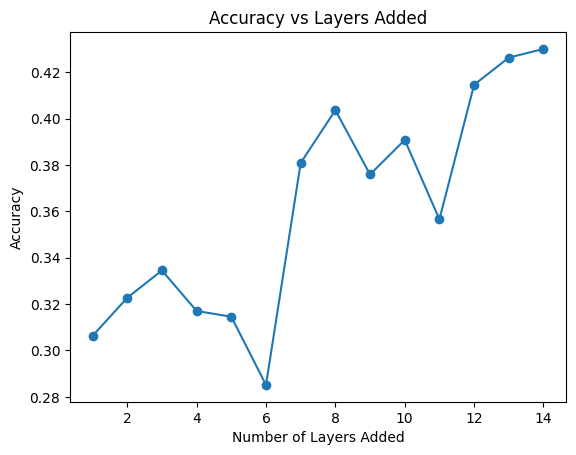

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

# Load and preprocess CIFAR-10 dataset
(train_images, train_labels), (test_images, test_labels) = cifar10.load_data()
train_images, test_images = train_images / 255.0, test_images / 255.0
train_labels, test_labels = to_categorical(train_labels), to_categorical(test_labels)

# Build the initial model without Dense and Flatten layers
def build_initial_model():
    model = models.Sequential()
    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
    model.add(layers.Flatten())
    model.add(layers.Dense(10, activation='softmax'))
    return model

# Function to add a Conv2D layer to the model
def add_conv_layer(model):
    # Create a new model excluding the last two layers
    new_model = models.Sequential()
    for layer in model.layers[:-2]:
        new_model.add(layer)

    # Add a new Conv2D layer
    new_model.add(layers.Conv2D(32, (3, 3), activation='relu'))
    # Skip MaxPooling2D to avoid negative dimensions
    # new_model.add(layers.MaxPooling2D((2, 2)))

    # Re-add Flatten layer
    new_model.add(layers.Flatten())

    # Create a new Dense layer with the same configuration
    dense_layer = layers.Dense(10, activation='softmax', kernel_initializer=model.layers[-1].kernel_initializer)

    # Add the new Dense layer
    new_model.add(dense_layer)

    # Freeze the Dense layer
    new_model.layers[-1].trainable = False

    return new_model

# Greedy layerwise training
def greedy_layerwise_training(model, num_layers_to_add, train_base=True):
    accuracies = []

    for i in range(num_layers_to_add):
        # Freeze existing layers
        for layer in model.layers[:-2]:
            layer.trainable = False

        # Add a new Conv2D layer and re-add Flatten layer
        model = add_conv_layer(model)

        # Compile the model
        model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

        # Display model summary before and after adding the layer
        print(f'\nModel summary before training added layer {i + 1}:\n')
        model.summary()

        if train_base:
            # Train the model on the CIFAR-10 dataset for one epoch
            history = model.fit(train_images, train_labels, epochs=1, validation_data=(test_images, test_labels), verbose=0)
            accuracies.append(history.history['accuracy'][0])

        # Unfreeze the last added Conv2D layer for training
        model.layers[-2].trainable = True

        # Train only the newly added Conv2D layer and collect accuracy
        history = model.fit(train_images, train_labels, epochs=25, batch_size=32, validation_data=(test_images, test_labels), verbose=0)
        accuracies.append(history.history['accuracy'][0])

        # Display model summary after training the added layer
        print(f'\nModel summary after training added layer {i + 1}:\n')
        model.summary()

    return model, accuracies

# Build the initial model
initial_model = build_initial_model()

# Train the base model
initial_model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
initial_model.fit(train_images, train_labels, epochs=25, batch_size=32, validation_data=(test_images, test_labels))

# Perform greedy layerwise training by adding convolutional layers
final_model, layer_accuracies = greedy_layerwise_training(initial_model, num_layers_to_add=14, train_base=False)

# Evaluate the final model
test_loss, test_acc = final_model.evaluate(test_images, test_labels)
print(f'\nFinal model test accuracy: {test_acc}')

# Save accuracies to a file
with open('layer_accuracies.txt', 'w') as file:
    for accuracy in layer_accuracies:
        file.write(f'{accuracy}\n')

# Plot accuracy vs layer added
plt.plot(range(1, len(layer_accuracies) + 1), layer_accuracies, marker='o')
plt.title('Accuracy vs Layers Added')
plt.xlabel('Number of Layers Added')
plt.ylabel('Accuracy')
plt.show()
